<a href="https://colab.research.google.com/github/teticio/audio-diffusion/blob/master/notebooks/test-model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
    # are we running on Google Colab?
    import google.colab
    !git clone -q https://github.com/teticio/audio-diffusion.git
    %cd audio-diffusion
    !pip install -q -r requirements.txt
except:
    pass

In [2]:
import os
import sys
sys.path.insert(0, os.path.dirname(os.path.abspath("")))

In [3]:
import random
from PIL import Image
from src.mel import Mel
from IPython.display import Audio
from datasets import load_dataset
from diffusers import DDPMPipeline

In [4]:
mel = Mel(x_res=256, y_res=256)

### Run model inference to generate mel spectrogram

In [5]:
model_id = "teticio/audio-diffusion-256"
ddpm = DDPMPipeline.from_pretrained(model_id)  # you can replace DDPMPipeline with DDIMPipeline or PNDMPipeline for faster inference
images = ddpm(output_type="numpy")["sample"]
images = (images * 255).round().astype("uint8").transpose(0, 3, 1, 2)

  0%|          | 0/1000 [00:00<?, ?it/s]

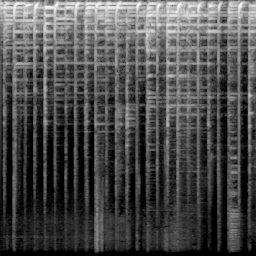

In [6]:
image = Image.fromarray(images[0][0])
image

### Transform mel spectrogram to audio

In [7]:
audio = mel.image_to_audio(image)
Audio(data=audio, rate=mel.get_sample_rate())

### Compare results with random sample from training set

In [8]:
ds = load_dataset('teticio/audio-diffusion-256')

Using custom data configuration teticio--audio-difussion-data-256-67e42008226ba2a6
Reusing dataset parquet (/home/teticio/.cache/huggingface/datasets/teticio___parquet/teticio--audio-difussion-data-256-67e42008226ba2a6/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/1 [00:00<?, ?it/s]

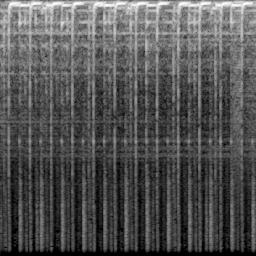

In [9]:
image = random.choice(ds['train'])['image']
image

In [10]:
audio = mel.image_to_audio(image)
Audio(data=audio, rate=mel.get_sample_rate())

### Push model to hub

In [ ]:
from diffusers.hub_utils import init_git_repo, push_to_hub


class AttributeDict(dict):

    def __getattr__(self, attr):
        return self[attr]

    def __setattr__(self, attr, value):
        self[attr] = value


args = AttributeDict({
    "hub_model_id":
    "teticio/audio-diffusion-256",
    "output_dir":
    "../ddpm-ema-audio-256-repo",
    "local_rank":
    -1,
    "hub_token":
    open(os.path.join(os.environ['HOME'], '.huggingface/token'), 'rt').read(),
    "hub_private_repo":
    False,
    "overwrite_output_dir":
    False
})

repo = init_git_repo(args, at_init=True)
ddpm = DDPMPipeline.from_pretrained('../ddpm-ema-audio-256')
push_to_hub(args, ddpm, repo)